# Checking, Extracting and Ploting Respiration activity features

Single belt chest stretch measurements of respiration start with a wave that needs to be translated into features we can interprete. 

## Data Quality check
Check the raw respiration wave to evaluate whether it is catching respiratory waves clearly enough to be processed

## Extracting features - Inspiration onsets
Across all forms of respiration, inspiration is an active phase, the results of coordinated muscle contractions. Identifying the onsets of inspirations from the waves sometimes works well and sometimes is difficult to untangle from motion artifacts

## Extracting features - Respiration rate and Sequential differences
Changes in respiration rate can be a consequence of activity, attention, and affect. The feature of respiration rate is often a summary value for an interval but can also be tracked breath-by-breath.


In [258]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import respy as rp


In [259]:
%load_ext autoreload
%autoreload 1
%aimport rp2
%aimport qex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
%reload_ext autoreload

In [132]:
demofile_loc = './demodata/EQ/'
df_datafiles = qex.qiosk_recordings(demofile_loc)
df_datafiles

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,ECGloc,SubjectNames,SENSOR ID,SUBJECT ID,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,WW501,5022238,241203,4,DATA-WW501-5022238-24120304.CSV,csv,1816,2024-12-03 14:49:34+00:00,2024-12-03 14:54:19+00:00,...,./demodata/EQ/ECG-WW501-5022238-24120304.csv,[WW501],5022238.0,WW501,240.0,34.0,0.0,1.0,Stationary,Upright
1,DATA,LS402,5022204,241203,4,DATA-LS402-5022204-24120304.CSV,csv,1825,2024-12-03 14:49:35+00:00,2024-12-03 14:54:20+00:00,...,./demodata/EQ/ECG-LS402-5022204-24120304.csv,[LS402],5022204.0,LS402,77.0,98.0,0.0,0.0,MovingSlowly,Upright
2,DATA,WW501,5022238,241203,1,DATA-WW501-5022238-24120301.CSV,csv,2745,2024-12-03 17:29:34+00:00,2024-12-03 17:37:04+00:00,...,./demodata/EQ/ECG-WW501-5022238-24120301.csv,[WW501],5022238.0,WW501,131.0,97.0,0.0,0.0,Stationary,Upright
3,DATA,LS402,5022204,241203,1,DATA-LS402-5022204-24120301.CSV,csv,2717,2024-12-03 17:29:35+00:00,2024-12-03 17:37:05+00:00,...,./demodata/EQ/ECG-LS402-5022204-24120301.csv,[LS402],5022204.0,LS402,77.0,98.0,0.0,0.0,Stationary,Upright
4,DATA,WW501,5022238,241203,3,DATA-WW501-5022238-24120303.CSV,csv,8731,2024-12-03 20:30:04+00:00,2024-12-03 20:55:19+00:00,...,./demodata/EQ/ECG-WW501-5022238-24120303.csv,[WW501],5022238.0,WW501,101.0,99.0,0.0,0.0,Stationary,Upright
5,DATA,LS402,5022204,241203,3,DATA-LS402-5022204-24120303.CSV,csv,8646,2024-12-03 20:30:05+00:00,2024-12-03 20:55:20+00:00,...,./demodata/EQ/ECG-LS402-5022204-24120303.csv,[LS402],5022204.0,LS402,77.0,99.0,0.0,0.0,Stationary,Upright
6,DATA,WW501,5022238,241203,2,DATA-WW501-5022238-24120302.CSV,csv,4912,2024-12-03 20:55:04+00:00,2024-12-03 21:08:49+00:00,...,./demodata/EQ/ECG-WW501-5022238-24120302.csv,[WW501],5022238.0,WW501,122.0,98.0,0.0,0.0,MovingSlowly,Upright
7,DATA,LS402,5022204,241203,2,DATA-LS402-5022204-24120302.CSV,csv,4882,2024-12-03 20:55:05+00:00,2024-12-03 21:08:50+00:00,...,./demodata/EQ/ECG-LS402-5022204-24120302.csv,[LS402],5022204.0,LS402,82.0,98.0,0.0,0.0,MovingSlowly,Upright


# Extracting respiratory features, by breath
Note: this cell changes the index of the data opened to seconds since the first sample. The functions employed here depends on a dataframe index of Time (s), not datetime formate.

In [236]:
recID = 5
V = pd.read_csv(df_datafiles.loc[recID,'RESPloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()

Resp = V.set_index('Time_s').copy()

# show the second-wise index, a rapid sample rate, 256 Hz
Resp.iloc[:10,:]

,DateTime,Breathing
Time_s,,
0.000,2024-12-03 20:30:03.925000+00:00,841
0.039,2024-12-03 20:30:03.964000+00:00,829
0.078,2024-12-03 20:30:04.003000+00:00,816
0.117,2024-12-03 20:30:04.042000+00:00,805
0.156,2024-12-03 20:30:04.081000+00:00,795
0.196,2024-12-03 20:30:04.121000+00:00,785
0.235,2024-12-03 20:30:04.160000+00:00,777
0.274,2024-12-03 20:30:04.199000+00:00,767
0.313,2024-12-03 20:30:04.238000+00:00,759


## Data Quality check

Reading the quality of measurements from a few samples is not so easy. The respiration wave is a unitless relative value, an estimate of chest circumference that is uncalibrated and adaptive to extremes in variation. The same values do not always correspond to the same circumference of chest or quantity of change between samples.

What we need to see is the contour of waves over time, showing the alternation of inspriration and expiration within a reasonable amount of time. 

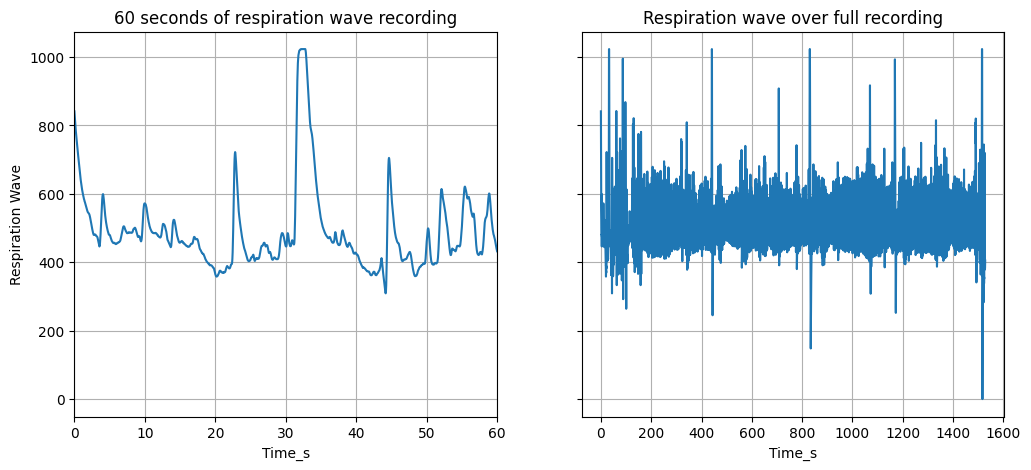

In [237]:
fig,(axes) = plt.subplots(1,2,figsize=(12,5),sharey=True)
Resp.loc[:60,'Breathing'].plot(ax = axes[0])
axes[0].grid()
axes[0].set(xlim=[0,60],ylabel = 'Respiration Wave', title = '60 seconds of respiration wave recording')
Resp['Breathing'].plot(ax = axes[1])
axes[1].grid()
axes[1].set(title = 'Respiration wave over full recording')

plt.show()


This looks like a respiratory wave, with fast increases (inspirations) and slower decreases and time in between. This measurement is from an interval of activity that produces irregular breathing cycles. 

## Extracting features - Inspiration onsets
The basis of tracking respiratory action is identify respiratory actions in the wave measurements. Here we use a heuristic algorithm to identify when inspirations begin (insp onset) and when expirations begin. With these moments identified, a host of other qualities about each breath can be evaluated.

In [172]:
Inspirations = rp2.EQ_Inspiration_Extract(Resp['Breathing'])
Inspirations['In']

Clipped!


0         3.477
1         6.406
2         9.375
3        12.227
4        13.633
         ...   
507    1513.242
508    1516.563
509    1521.406
510    1523.203
511    1524.414
Name: In, Length: 512, dtype: float64

The inspiration onsets are reported in seconds 

Note: the little "Clipped!" notification that popped up is a warning that at least one respiratory cycle is clipped in this recording, meaning the shape of the top of a big breath was cutoff, obfuscating the onset of expiration a little. This happens with these Equivital vest measurements when people suddenly change posture and switch from more shallow quiet breathing to more extreme respiratory actions. Usually this clipping only happens a few times per recording.


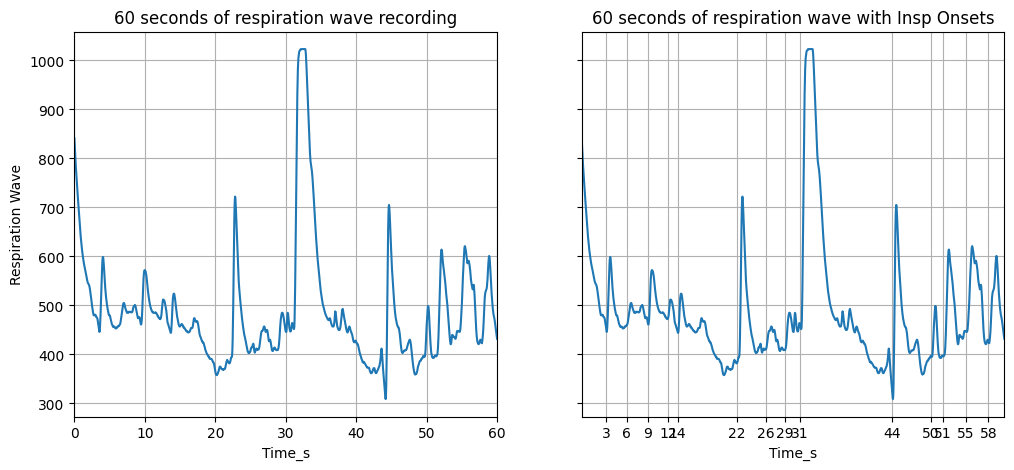

In [173]:
fig,(axes) = plt.subplots(1,2,figsize=(12,5),sharey=True)
Resp.loc[:60,'Breathing'].plot(ax = axes[0])
axes[0].grid()
axes[0].set(xlim=[0,60],ylabel = 'Respiration Wave', title = '60 seconds of respiration wave recording')

Resp.loc[:60,'Breathing'].plot(ax = axes[1])
axes[1].set(xticks = Inspirations['In'].values)
axes[1].set(xlim=[0,60],ylabel = 'Respiration Wave', title = '60 seconds of respiration wave with Insp Onsets')
axes[1].grid()
plt.show()

From these inspiration onsets we can evaluate the full respiratory cycles AND use these calculated breaths to normalise the recording a little to make measurements comparable between people. Here Breaths is a larger set of descriptive features and Insp_seq adds a number of sequential features, how one breath differs from the previous.

In [241]:
Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(Resp['Breathing']),Resp['Breathing'])
Insp_seq = rp2.quickcarresp(Breaths)
Insp_seq

Clipped!


,In,Ex,In_C,Ex_C,IDepth,EDepth,Insp_T,Period_T,Exp_T,IE_Ratio,IE_DR,Insp_V,Exp_V,RelID,RelED,dPT,dIT,dID,relD,Categories
0,3.477,4.102,452,596,144,136.0,0.625,2.929,2.304,0.271267,1.058824,230.400000,59.027778,NaN,NaN,NaN,NaN,NaN,NaN,Disturbed
1,6.406,6.953,460,504,44,39.0,0.547,2.969,2.422,0.225846,1.128205,80.438757,16.102395,NaN,NaN,0.013564,0.133303,1.185624,NaN,Disturbed
2,9.375,10.039,465,571,106,98.0,0.664,2.852,2.188,0.303473,1.081633,159.638554,44.789762,1.341772,1.000000,0.040205,0.193833,0.879249,0.293991,Disturbed
3,12.227,12.617,473,512,39,67.0,0.390,1.406,1.016,0.383858,0.582090,100.000000,65.944882,0.493671,0.683673,0.707272,0.532135,0.999877,0.705886,Disturbed
4,13.633,14.141,445,524,79,141.0,0.508,8.438,7.930,0.064061,0.560284,155.511811,17.780580,1.000000,1.438776,1.791997,0.264335,0.705886,0.000000,Disturbed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,1513.242,1514.571,462,1022,560,1021.0,1.329,3.321,1.992,0.667169,0.548482,421.369451,512.550201,1.278539,2.812672,0.299698,0.307695,1.186273,0.245718,Disturbed
508,1516.563,1519.414,1,656,655,373.0,2.851,4.843,1.992,1.431225,1.756032,229.743949,187.248996,1.495434,1.027548,0.377268,0.763243,0.156698,0.402416,Disturbed
509,1521.406,1522.305,283,721,438,363.0,0.899,1.797,0.898,1.001114,1.206612,487.208009,404.231626,1.000000,NaN,0.991416,1.154142,0.402416,0.000000,Disturbed
510,1523.203,1523.789,358,603,245,210.0,0.586,1.211,0.625,0.937600,1.166667,418.088737,336.000000,NaN,NaN,0.394672,0.427963,0.580961,NaN,Disturbed


We can chose which of these features to explore graphically or statistically, to evaluate respiratory behaviour during specific activities and conditions. 

Here are examples of plots from a few features.

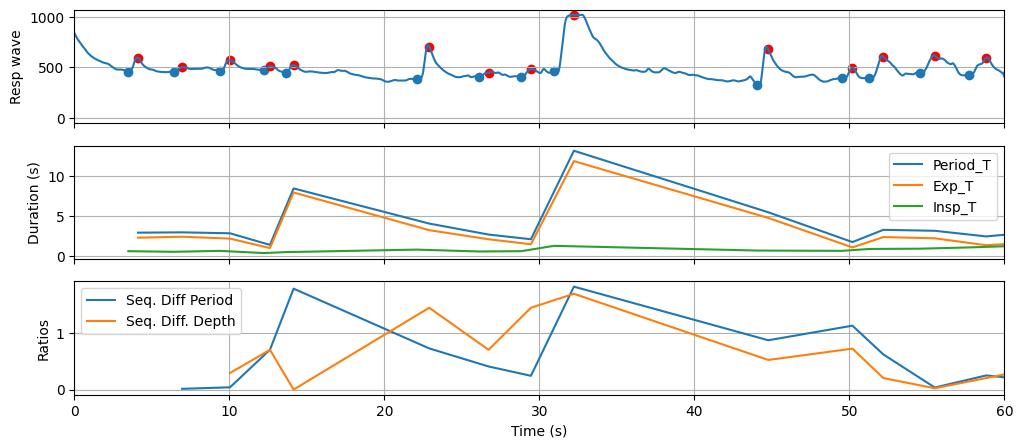

In [175]:
fig,(axes) = plt.subplots(3,1,figsize=(12,5),sharex=True)
axes[0].scatter(Insp_seq['In'],Insp_seq['In_C'],label = 'Inspiration onset')
axes[0].scatter(Insp_seq['Ex'],Insp_seq['Ex_C'],c='r',label = 'Expiration onset')
Resp['Breathing'].plot(ax = axes[0],label='Respiration wave')
axes[0].set(ylabel = 'Resp wave')
axes[0].grid()
axes[1].plot(Insp_seq['Ex'],Insp_seq[['Period_T','Exp_T']],label = ['Period_T','Exp_T'])
axes[1].plot(Insp_seq['In'],Insp_seq['Insp_T'],label = 'Insp_T')
axes[1].set(xlim=[0,60],ylabel='Duration (s)',xlabel='Time (s)')
axes[1].grid()
axes[1].legend()

axes[2].plot(Insp_seq['Ex'],Insp_seq[['dPT','relD']],label = ['Seq. Diff Period','Seq. Diff. Depth'])
axes[2].set(xlim=[0,60],ylabel='Ratios',xlabel='Time (s)')
axes[2].grid()
axes[2].legend()
plt.show()


Breathing in this interval is quite variable, some times short breaths, some times long, sometimes shallow, sometimes deep (and clipped!) while the breathing cycles towards the end are getting more consistently short. 

Lets look at another minute of this same recording.

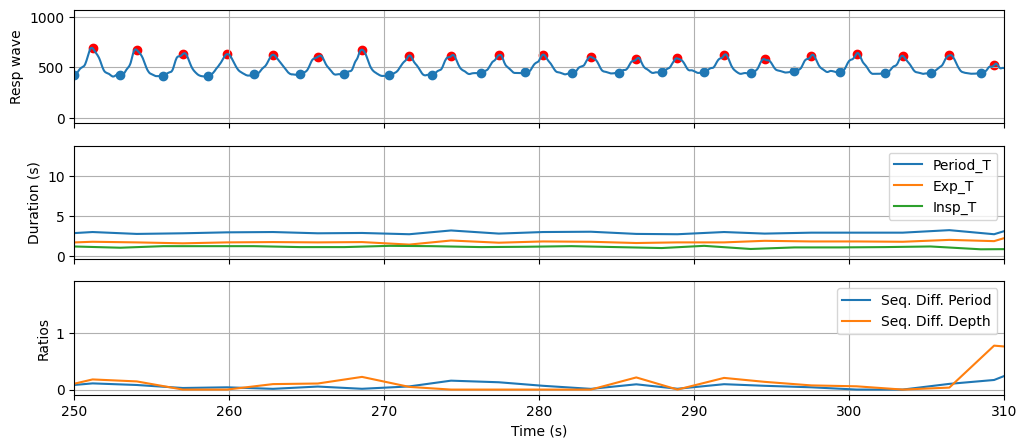

In [179]:
fig,(axes) = plt.subplots(3,1,figsize=(12,5),sharex=True)
axes[0].scatter(Insp_seq['In'],Insp_seq['In_C'],label = 'Inspiration onset')
axes[0].scatter(Insp_seq['Ex'],Insp_seq['Ex_C'],c='r',label = 'Expiration onset')
Resp['Breathing'].plot(ax = axes[0],label='Respiration wave')
axes[0].set(ylabel = 'Resp wave')

axes[0].grid()
axes[1].plot(Insp_seq['Ex'],Insp_seq[['Period_T','Exp_T']],label = ['Period_T','Exp_T'])
axes[1].plot(Insp_seq['In'],Insp_seq['Insp_T'],label = 'Insp_T')
axes[1].set(ylabel='Duration (s)',xlabel='Time (s)')
axes[1].grid()
axes[1].legend()

axes[2].plot(Insp_seq['Ex'],Insp_seq[['dPT','relD']],label = ['Seq. Diff. Period','Seq. Diff. Depth'])
axes[2].set(xlim=[250,310],ylabel='Ratios',xlabel='Time (s)')
axes[2].grid()
axes[2].legend()
plt.show()


In this time interval, the participant's breathing is relatively regular, shallow, and nearly even in duration of inspiration and expiration phases. This quality of consistently can be seen in the respiratory features plotted, little variation in the durations ins correspondingly low difference ratios from breath to breath for almost this whole sequence. We can use these features to look at longer intervals of time.  

## Plot respiration features against event information
Data session 4 and 5 were recorded from two people at the start of a little concert of Norwegian fiddle music. We can look at the respiration features against what was happening in the concert, moment by moment, described inthe Concert_Events_Structure.csv file.

### Breathing and Listening

In [239]:
Events = pd.read_csv('./demodata/timing/Concert_Events_Structure.csv')

Events['Duration']=Events['TIME'].diff().shift(-1)
events_pallet = {'Applause':'red', 'Speech':'blue', 'Prime':'green', 'Music':'yellow'}

Now plot the duration of each respiratory cycle with the concurrent events colour coded.

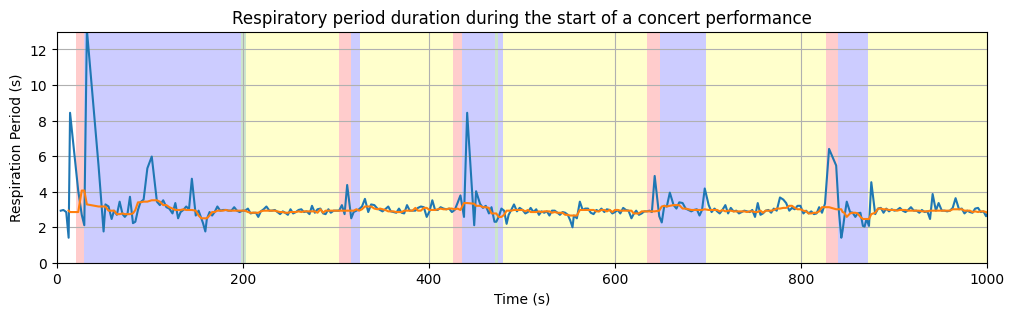

In [244]:
fig,(ax) = plt.subplots(1,1,figsize=(12,3),sharey=True)
ax.plot(Insp_seq['Ex'],Insp_seq['Period_T'],label = ['Period_T'])
ax.plot(Insp_seq['Ex'],Insp_seq['Period_T'].rolling(7,center=True).median(),label = ['Period_T'])

ax.grid()
for i,row in Events.iloc[:20,:].iterrows():
    ax.axvspan(row['TIME'],row['TIME']+row['Duration'], facecolor=events_pallet[row['LABEL']],alpha = 0.2)
ax.set(xlim = [0,1000],ylim = [0,13],ylabel='Respiration Period (s)',xlabel = 'Time (s)')
plt.title('Respiratory period duration during the start of a concert performance') 
plt.show()

The duration of individual breaths are extremely variable in the first few seconds of this recording interval, before the group applauded and the performers started addressing the group verbally. 

Through the speach intervals (blue) and music intervals (yellow) the breathing period looks to be relatively stable for many breaths at a time, interupted by big deviations here and there. 

This change in consistency should also be visible in the sequential difference features.

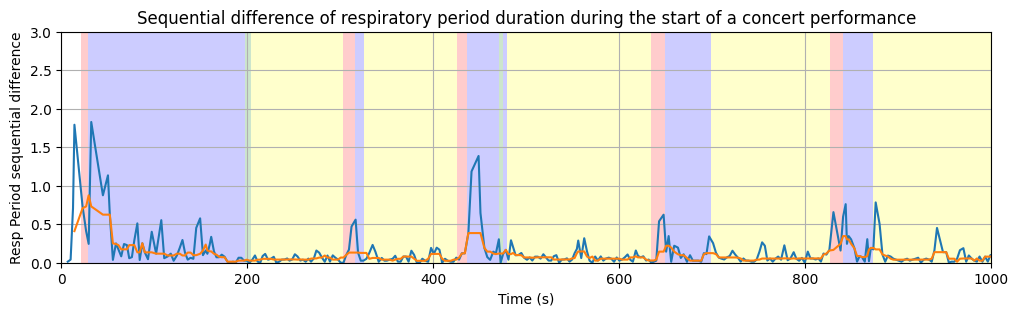

In [245]:
fig,(ax) = plt.subplots(1,1,figsize=(12,3),sharey=True)
ax.plot(Insp_seq['Ex'],Insp_seq['dPT'],label = ['Period_T'])
ax.plot(Insp_seq['Ex'],Insp_seq['dPT'].rolling(7,center=True).median(),label = ['Period_T'])

ax.grid()
for i,row in Events.iloc[:20,:].iterrows():
    ax.axvspan(row['TIME'],row['TIME']+row['Duration'], facecolor=events_pallet[row['LABEL']],alpha = 0.2)
ax.set(ylabel='Resp Period sequential difference',xlabel='Time (s)',xlim = [0,1000],ylim = [0,3])

plt.title('Sequential difference of respiratory period duration during the start of a concert performance') 

plt.show()

We can look at the same participant during an interval of dancing tooEvents = pd.read_csv('./demodata/timing/Concert_Events_Structure.csv')

### Breathing and Dancing

In [260]:
Events = pd.read_csv('./demodata/timing/Dancing_Events_Structure.csv')
Events = Events.loc[Events.Structure.str.len()>0,:].copy()
Events['Duration']=Events['TIME'].diff().shift(-1)
events_pallet = {'D':'blue','T':'green','M':'yellow','A':'red', }

In [261]:
recID = 7
V = pd.read_csv(df_datafiles.loc[recID,'RESPloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()
Resp = V.set_index('Time_s').copy()
Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(Resp['Breathing']),Resp['Breathing'])
Insp_seq = rp2.quickcarresp(Breaths)
Insp_seq

,In,Ex,In_C,Ex_C,IDepth,EDepth,Insp_T,Period_T,Exp_T,IE_Ratio,IE_DR,Insp_V,Exp_V,RelID,RelED,dPT,dIT,dID,relD,Categories
0,0.547,1.289,458,600,142,148.0,0.742,2.773,2.031,0.365337,0.959459,191.374663,72.870507,NaN,NaN,NaN,NaN,NaN,NaN,Disturbed
1,3.320,4.219,452,689,237,247.0,0.899,2.422,1.523,0.590282,0.959514,263.626251,162.179908,NaN,NaN,0.135336,0.191934,0.512233,NaN,Disturbed
2,5.742,6.562,442,662,220,256.0,0.820,2.500,1.680,0.488095,0.859375,268.292683,152.380952,1.000000,1.036437,0.031697,0.091979,0.074433,0.000000,Quiet
3,8.242,9.219,406,728,322,280.0,0.977,4.297,3.320,0.294277,1.150000,329.580348,84.337349,1.358650,1.093750,0.541626,0.175182,0.380924,0.306491,Disturbed
4,12.539,13.242,448,596,148,131.0,0.703,2.305,1.602,0.438826,1.129771,210.526316,81.772784,0.501695,0.467857,0.622836,0.329130,0.777339,0.689763,Disturbed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,818.515,819.414,347,672,325,237.0,0.899,3.360,2.461,0.365299,1.371308,361.512792,96.302316,1.000000,0.864964,0.447404,0.001113,0.205136,0.000000,Quiet
331,821.875,822.578,435,580,145,131.0,0.703,3.672,2.969,0.236780,1.106870,206.258890,44.122600,0.363409,0.301843,0.088795,0.245926,0.807091,1.012228,Disturbed
332,825.547,826.719,449,1021,572,880.0,1.172,3.359,2.187,0.535894,0.650000,488.054608,402.377686,1.355450,NaN,0.089093,0.511110,1.372405,0.304134,Disturbed
333,828.906,829.961,141,617,476,516.0,1.055,2.305,1.250,0.844000,0.922481,451.184834,412.800000,NaN,NaN,0.376563,0.105171,0.183721,NaN,Quiet


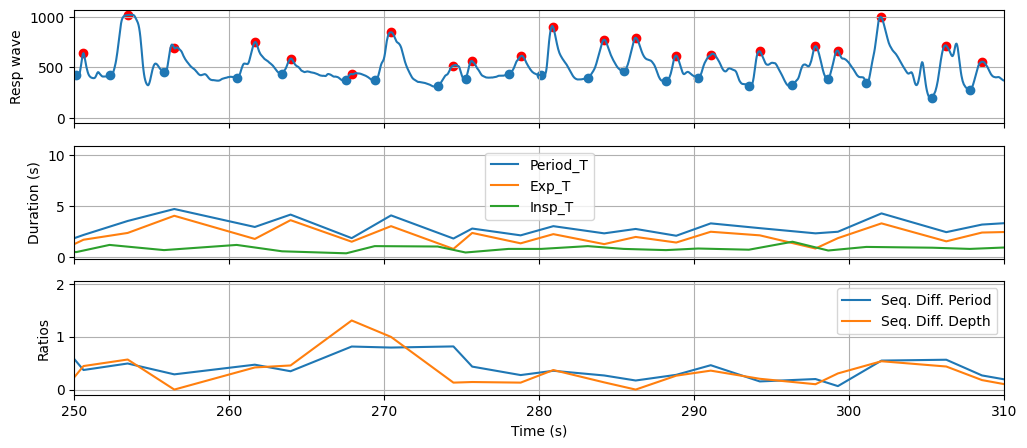

In [262]:
fig,(axes) = plt.subplots(3,1,figsize=(12,5),sharex=True)
axes[0].scatter(Insp_seq['In'],Insp_seq['In_C'],label = 'Inspiration onset')
axes[0].scatter(Insp_seq['Ex'],Insp_seq['Ex_C'],c='r',label = 'Expiration onset')
Resp['Breathing'].plot(ax = axes[0],label='Respiration wave')
axes[0].set(ylabel = 'Resp wave')

axes[0].grid()
axes[1].plot(Insp_seq['Ex'],Insp_seq[['Period_T','Exp_T']],label = ['Period_T','Exp_T'])
axes[1].plot(Insp_seq['In'],Insp_seq['Insp_T'],label = 'Insp_T')
axes[1].set(ylabel='Duration (s)',xlabel='Time (s)')
axes[1].grid()
axes[1].legend()

axes[2].plot(Insp_seq['Ex'],Insp_seq[['dPT','relD']],label = ['Seq. Diff. Period','Seq. Diff. Depth'])
axes[2].set(xlim=[250,310],ylabel='Ratios',xlabel='Time (s)')
axes[2].grid()
axes[2].legend()
plt.show()

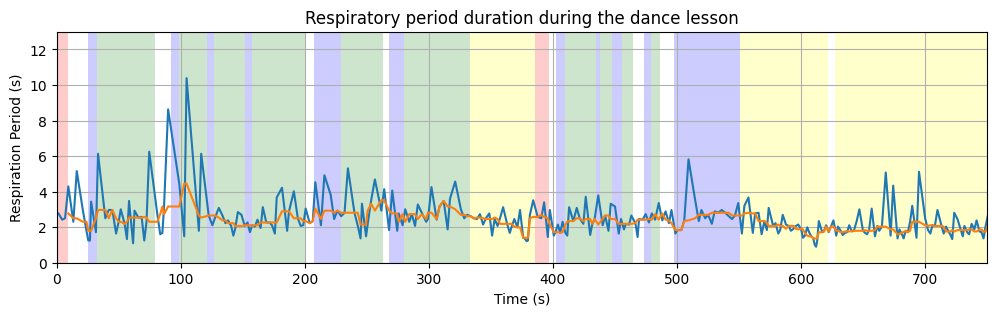

In [267]:
fig,(ax) = plt.subplots(1,1,figsize=(12,3),sharey=True)
ax.plot(Insp_seq['Ex'],Insp_seq['Period_T'],label = ['Period_T'])
ax.plot(Insp_seq['Ex'],Insp_seq['Period_T'].rolling(7,center=True).median(),label = ['Period_T'])

ax.grid()
for i,row in Events.iloc[:35,:].iterrows():
    if row['Structure'][0] in events_pallet.keys():
        ax.axvspan(row['TIME'],row['TIME']+row['Duration'], facecolor=events_pallet[row['Structure'][0]],alpha = 0.2)
ax.set(xlim = [0,750],ylim = [0,13],ylabel='Respiration Period (s)',xlabel = 'Time (s)')
plt.title('Respiratory period duration during the dance lesson') 
plt.show()

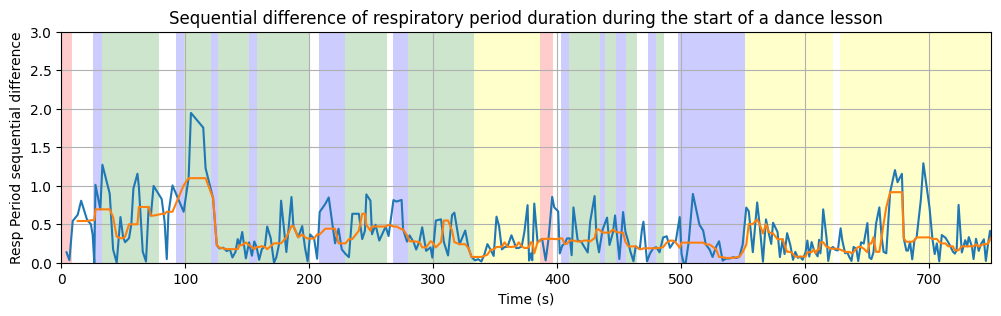

In [268]:
fig,(ax) = plt.subplots(1,1,figsize=(12,3),sharey=True)
ax.plot(Insp_seq['Ex'],Insp_seq['dPT'],label = ['Period_T'])
ax.plot(Insp_seq['Ex'],Insp_seq['dPT'].rolling(7,center=True).median(),label = ['Period_T'])

ax.grid()
for i,row in Events.iloc[:35,:].iterrows():
    if row['Structure'][0] in events_pallet.keys():
        ax.axvspan(row['TIME'],row['TIME']+row['Duration'], facecolor=events_pallet[row['Structure'][0]],alpha = 0.2)
ax.set(xlim = [0,750],ylim = [0,3],ylabel='Resp Period sequential difference',xlabel = 'Time (s)')

plt.title('Sequential difference of respiratory period duration during the start of a dance lesson') 

plt.show()

### Breathing and Singing

In [251]:
Events = pd.read_csv('./demodata/timing/Singing_Events_Structure.csv')
Events
Events = Events.loc[Events.Type.str.len()>0,:].copy()
Events['Duration']=Events['TIME'].diff().shift(-1)
events_pallet = {'D':'blue','T':'green','M':'yellow','A':'red', }

In [252]:
recID = 3
V = pd.read_csv(df_datafiles.loc[recID,'RESPloc'])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V['Time_s'] = (V['DateTime']-V.loc[0,'DateTime']).dt.total_seconds()
Resp = V.set_index('Time_s').copy()
Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(Resp['Breathing']),Resp['Breathing'])
Insp_seq = rp2.quickcarresp(Breaths)
Insp_seq

Clipped!


,In,Ex,In_C,Ex_C,IDepth,EDepth,Insp_T,Period_T,Exp_T,IE_Ratio,IE_DR,Insp_V,Exp_V,RelID,RelED,dPT,dIT,dID,relD,Categories
0,0.390,1.601,400,768,368,478.0,1.211,3.125,1.914,0.632706,0.769874,303.881090,249.738767,NaN,NaN,NaN,NaN,NaN,NaN,Disturbed
1,3.515,5.390,290,1022,732,776.0,1.875,7.539,5.664,0.331038,0.943299,390.400000,137.005650,NaN,NaN,0.880655,0.437162,0.687698,NaN,Disturbed
2,11.054,13.281,246,565,319,193.0,2.227,4.258,2.031,1.096504,1.652850,143.242030,95.027080,0.866848,0.462830,0.571290,0.172047,0.830589,0.142892,Disturbed
3,15.312,17.070,372,797,425,417.0,1.758,4.297,2.539,0.692399,1.019185,241.751991,164.237889,1.332288,2.160622,0.009118,0.236479,0.286898,0.286898,Quiet
4,19.609,20.039,380,433,53,15.0,0.430,1.406,0.976,0.440574,3.533333,123.255814,15.368852,0.438017,0.192308,1.117168,1.408147,2.081797,0.825499,Disturbed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,442.578,443.671,488,883,395,510.0,1.093,2.343,1.250,0.874400,0.774510,361.390668,408.000000,1.278317,2.562814,0.016351,0.692233,1.868012,0.245544,Disturbed
111,444.921,445.625,373,682,309,155.0,0.704,1.133,0.429,1.641026,1.993548,438.920455,361.305361,1.000000,1.000000,0.726563,0.439903,0.245544,0.000000,Disturbed
112,446.054,446.679,527,850,323,491.0,0.625,3.086,2.461,0.253962,0.657841,516.800000,199.512393,1.045307,NaN,1.002007,0.119027,0.044311,0.044311,Disturbed
113,449.140,450.156,359,521,162,111.0,1.016,2.227,1.211,0.838976,1.459459,159.448819,91.659785,NaN,NaN,0.326220,0.485877,0.690056,NaN,Disturbed


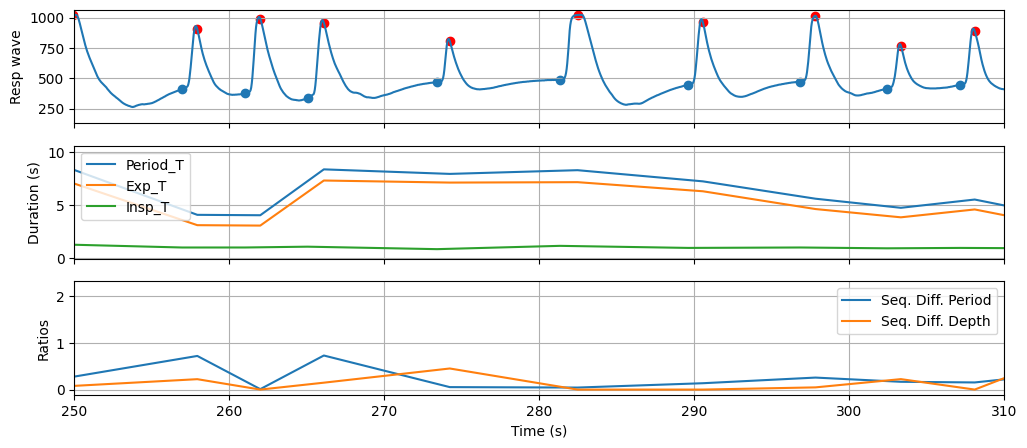

In [253]:
fig,(axes) = plt.subplots(3,1,figsize=(12,5),sharex=True)
axes[0].scatter(Insp_seq['In'],Insp_seq['In_C'],label = 'Inspiration onset')
axes[0].scatter(Insp_seq['Ex'],Insp_seq['Ex_C'],c='r',label = 'Expiration onset')
Resp['Breathing'].plot(ax = axes[0],label='Respiration wave')
axes[0].set(ylabel = 'Resp wave')

axes[0].grid()
axes[1].plot(Insp_seq['Ex'],Insp_seq[['Period_T','Exp_T']],label = ['Period_T','Exp_T'])
axes[1].plot(Insp_seq['In'],Insp_seq['Insp_T'],label = 'Insp_T')
axes[1].set(ylabel='Duration (s)',xlabel='Time (s)')
axes[1].grid()
axes[1].legend()

axes[2].plot(Insp_seq['Ex'],Insp_seq[['dPT','relD']],label = ['Seq. Diff. Period','Seq. Diff. Depth'])
axes[2].set(xlim=[250,310],ylabel='Ratios',xlabel='Time (s)')
axes[2].grid()
axes[2].legend()
plt.show()

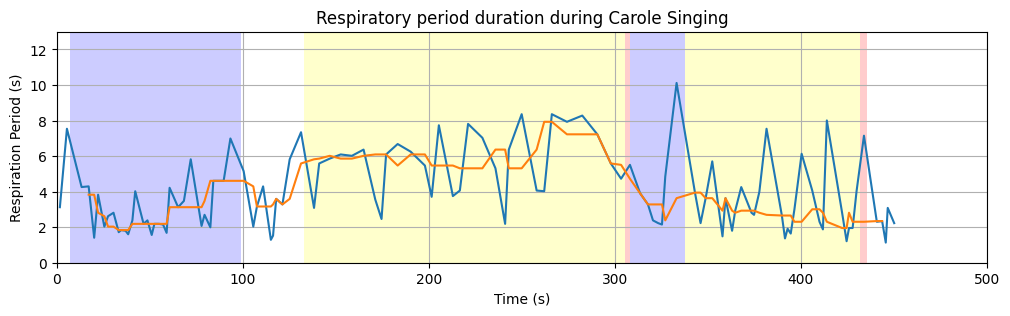

In [255]:
fig,(ax) = plt.subplots(1,1,figsize=(12,3),sharey=True)
ax.plot(Insp_seq['Ex'],Insp_seq['Period_T'],label = ['Period_T'])
ax.plot(Insp_seq['Ex'],Insp_seq['Period_T'].rolling(7,center=True).median(),label = ['Period_T'])

ax.grid()
for i,row in Events.iloc[:35,:].iterrows():
    if row['Type'][0] in events_pallet.keys():
        ax.axvspan(row['TIME'],row['TIME']+row['Duration'], facecolor=events_pallet[row['Type'][0]],alpha = 0.2)
ax.set(xlim = [0,500],ylim = [0,13],ylabel='Respiration Period (s)',xlabel = 'Time (s)')
plt.title('Respiratory period duration during Carole Singing') 
plt.show()

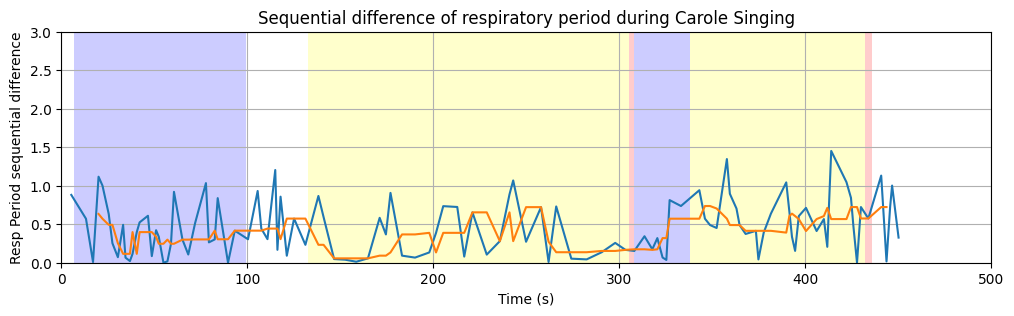

In [257]:
fig,(ax) = plt.subplots(1,1,figsize=(12,3),sharey=True)
ax.plot(Insp_seq['Ex'],Insp_seq['dPT'],label = ['Period_T'])
ax.plot(Insp_seq['Ex'],Insp_seq['dPT'].rolling(7,center=True).median(),label = ['Period_T'])
ax.grid()
for i,row in Events.iloc[:35,:].iterrows():
    if row['Type'][0] in events_pallet.keys():
        ax.axvspan(row['TIME'],row['TIME']+row['Duration'], facecolor=events_pallet[row['Type'][0]],alpha = 0.2)
ax.set(xlim = [0,500],ylim = [0,3],ylabel='Resp Period sequential difference',xlabel = 'Time (s)')
plt.title('Sequential difference of respiratory period during Carole Singing')
plt.show()